 ## Things to try to increase LB score

 1. Change way in which buffer region is constucted (Cross, Square, Ball)

 1. Change submission csv method to transpose rows and cols

 ### Submitting first 200 000, we have

 * 0.025533852 accuracy with only zeros.

 * 0.00043453 accuracy with only ones.

 * ie, 0.00043453 / (0.00043453 + 0.025533852) = 0.01673304097 ~= **1.67 %** rate of ones



 ....We should maybe consider that when setting threshold.

 ### Estimated time for getting **25m rows**:

 * One forward pass gives 40 000 rows

 * One forward pass takes approx. 0.5 sec

 * 25m / 40 000 = 625

 * 625 * 0.5 ~= 300 sec = **5 min**

 # Inference Notebook



 This notebook performs inference on test AOIs using the trained model. It reads the AOIs from shapefiles, processes each AOI through the model, and aggregates the results into final prediction tensors. The predictions are then converted into submission CSV files.



 The methods from `inference_utils.py` and `train_utils.py` are imported and used.

**TODO** change model to do 224 -> 224 or 224 -> 112. Otherwise, rounding errors m

 ## Imports and Setup

In [1]:
import os
import sys
import numpy as np
import torch
import random
from tqdm.notebook import tqdm

# Add the src directory to the sys.path
sys.path.append(os.path.abspath('..'))

# Import functions and constants from inference_utils and train_utils
from secret_runway_detection.inference_utils import (
    has_strip_tensors_to_submission_csv,
)

from secret_runway_detection.train_utils import (
    add_buffer_to_label,
)

from secret_runway_detection.model import get_model

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


 ## Configuration Parameters

In [2]:
DEBUG = False


# Tile and AOI parameters
# TILE_SIDE_LEN = 10.0  # in meters
# AOI_HEIGHT = 15270.0  # in meters
# AOI_WIDTH = 15410.0   # in meters

# # ROWS_COUNT = 1527  # Number of tile rows
# # COLUMNS_COUNT = 1541  # Number of tile columns

# assert (TILE_SIDE_LEN == AOI_HEIGHT / ROWS_COUNT) and (TILE_SIDE_LEN == AOI_WIDTH / COLUMNS_COUNT)

# # Model input and output dimensions
# INPUT_IMAGE_SIDE_LEN_PX = 224  # in pixels
# TILES_PER_INPUT_AREA_LEN = 224  # Number of tiles per side in one input area

# # Number of input areas to cover the AOI
# INPUT_AREAS_VERTICALLY = 10
# INPUT_AREAS_HORIZONTALLY = 10

# Threshold for converting model outputs to binary predictions

# Path to the trained model checkpoint
RUN_PATH = 'esedx12/secret-runway-detection/50vu7qyn'

# Path to save the submission CSVs
SUBMISSION_CSV_DIR = 'submission_csvs'
os.makedirs(SUBMISSION_CSV_DIR, exist_ok=True)


 ## Load the Trained Model

In [3]:
# Load the W&B run
import wandb


train_run = wandb.Api().run(RUN_PATH)
train_run.name

'peachy-pine-103'

In [4]:
from pathlib import Path
from more_itertools import one

# Fetch the model artifact from the W&B run
artifacts = train_run.logged_artifacts()
model_artifacts = [a for a in artifacts if a.type == 'model']
artifact = one(model_artifacts)
state_dict_dir = artifact.download(root='../artifacts/')
state_dict_dir = Path(state_dict_dir)
state_dict_path = state_dict_dir / f'{train_run.name}.pth'
state_dict_path

# %%
model_type = train_run.config['model_type']
print(f"Model type: {model_type}")

# %%
# Now load the type backbone_config artifact the same way you loaded the model and put it in a temp directory
backbone_config_artifacts = [a for a in artifacts if a.type == 'backbone_config']
backbone_config_artifact = one(backbone_config_artifacts)
backbone_config_dir = backbone_config_artifact.download(root='../artifacts/')
backbone_config_dir = Path(backbone_config_dir)
backbone_config_path = backbone_config_dir / f'{train_run.name}.yaml'
backbone_config_path


# %%
list(artifacts)

for artifact in artifacts:
    print(artifact.type, artifact.name)

# %%
# Then load the model like this
# model = get_model(config['model_type'], BACKBONE_CFG_PATH, backbone_weights_path, output_size=config['resolution']).to(device)
sys.path.append(os.path.abspath('../GFM'))

from secret_runway_detection.model import get_model

BACKBONE_CFG_PATH = '../configs/gfm_config.yaml'
backbone_weights_path = '../simmim_pretrain/gfm.pth'


model = get_model(train_run.config['model_type'], BACKBONE_CFG_PATH, backbone_weights_path, output_size=train_run.config['resolution']).to(device)

# %%
# Load the Model from WandB, which we saved as state dict
# Load the Model from WandB, which we saved as state dict
state_dict = torch.load(state_dict_path, map_location=device)
incompatible_keys = model.load_state_dict(state_dict, strict=False)
print(f"Incompatible keys: {incompatible_keys}")
model.eval()

# %%
best_threshold = train_run.summary['best_threshold']


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


Model type: custom


wandb:   1 of 1 files downloaded.  


backbone_config gfm_config:v1
model model:v42
=> merge config from ../configs/gfm_config.yaml
Incompatible keys: <All keys matched successfully>


In [5]:

# THRESHOLD = 1 - ( (1 - train_run.summary['best_threshold']) / 2 )



## Load images of AOIs

In [6]:
# %% [markdown]
# ## Load AOI Mosaics Based on Shapefile Names and Check for Missing Mosaics

# %%
import os
import rasterio
import numpy as np

# Directory containing AOI shapefiles
AOI_SHAPEFILES_DIR = '../shp_test_AOIs/shp'  # Adjust the path as necessary

# Directory where the mosaic images are saved
mosaic_images_dir = '../aoi_mosaic_images'  # Adjust the path as necessary

# Initialize an empty dictionary to store the images
aoi_images_dict = {}

# List all shapefiles in the directory
aoi_shapefiles = [f for f in os.listdir(AOI_SHAPEFILES_DIR) if f.endswith('.shp')]

# Extract AOI IDs from the shapefile names
aoi_ids = [os.path.splitext(f)[0] for f in aoi_shapefiles]

if DEBUG:
    aoi_ids = aoi_ids[:1]  # Limit the number of AOIs to load for debugging

# Iterate over each AOI ID and attempt to load the corresponding mosaic
for aoi_id in aoi_ids:
    mosaic_filename = f'{aoi_id}_mosaic.tif'
    mosaic_file_path = os.path.join(mosaic_images_dir, mosaic_filename)
    print(f"Processing AOI: {aoi_id}")
    
    # Check if the mosaic file exists
    if not os.path.exists(mosaic_file_path):
        raise FileNotFoundError(f"Mosaic file not found for AOI {aoi_id}: {mosaic_file_path}")
    else:
        # Open the image using rasterio
        with rasterio.open(mosaic_file_path) as src:
            # Read the image bands
            img_data = src.read()
            # Store the image data in the dictionary
            aoi_images_dict[aoi_id] = img_data
        print(f"Mosaic image loaded for AOI: {aoi_id}")

print(f"\nLoaded {len(aoi_images_dict)} AOI images into the dictionary.")


Processing AOI: aoi_2021_04
Mosaic image loaded for AOI: aoi_2021_04
Processing AOI: aoi_2022_01
Mosaic image loaded for AOI: aoi_2022_01
Processing AOI: aoi_2024_01
Mosaic image loaded for AOI: aoi_2024_01
Processing AOI: aoi_2020_02
Mosaic image loaded for AOI: aoi_2020_02
Processing AOI: aoi_2021_01
Mosaic image loaded for AOI: aoi_2021_01
Processing AOI: aoi_2020_03
Mosaic image loaded for AOI: aoi_2020_03
Processing AOI: aoi_2020_01
Mosaic image loaded for AOI: aoi_2020_01
Processing AOI: aoi_2022_02
Mosaic image loaded for AOI: aoi_2022_02
Processing AOI: aoi_2023_01
Mosaic image loaded for AOI: aoi_2023_01
Processing AOI: aoi_2021_03
Mosaic image loaded for AOI: aoi_2021_03
Processing AOI: aoi_2021_02
Mosaic image loaded for AOI: aoi_2021_02

Loaded 11 AOI images into the dictionary.


 ## Run Inference on Each AOI

In [7]:
import gc
from memory_profiler import profile
import cv2


import numpy as np
import torch

def aoi_image_to_has_strip_confidence(model, aoi_image, model_input_size=192, stride=96):
    """
    Run inference on a large image using a sliding window approach with overlap and max aggregation.

    Args:
        model: The trained PyTorch model.
        large_image: Input image as a NumPy array of shape (C, H, W) or (H, W, C).
        model_input_size: Size of the input expected by the model.
        stride: Stride between patches (less than model_input_size for overlap).

    Returns:
        output_image: The aggregated output predictions over the large image.
    """
    # Ensure the image is a tensor of shape (C, H, W)
    if aoi_image.ndim == 2:
        aoi_image = aoi_image[np.newaxis, :, :]
    elif aoi_image.shape[0] <= 3:
        pass  # Already in (C, H, W) format
    else:
        aoi_image = np.transpose(aoi_image, (2, 0, 1))

    C, H, W = aoi_image.shape

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Initialize output and count arrays
    output_image = np.full((H, W), -np.inf, dtype=np.float32)  # For max aggregation

    # Slide over the image
    for y in range(0, H - model_input_size + 1, stride):
        for x in range(0, W - model_input_size + 1, stride):
            patch = aoi_image[:, y:y+model_input_size, x:x+model_input_size]
            input_tensor = torch.from_numpy(patch).unsqueeze(0).float().to(device)
            with torch.no_grad():
                output = model(input_tensor)
            output = output.squeeze().cpu().numpy()
            # Max aggregation
            output_image[y:y+model_input_size, x:x+model_input_size] = np.maximum(
                output_image[y:y+model_input_size, x:x+model_input_size],
                output
            )

    # Handle borders if necessary
    # Process the last patches along height
    for y in range(0, H - model_input_size + 1, stride):
        x = W - model_input_size
        patch = aoi_image[:, y:y+model_input_size, x:x+model_input_size]
        input_tensor = torch.from_numpy(patch).unsqueeze(0).float().to(device)
        with torch.no_grad():
            output = model(input_tensor)
        output = output.squeeze().cpu().numpy()
        output_image[y:y+model_input_size, x:x+model_input_size] = np.maximum(
            output_image[y:y+model_input_size, x:x+model_input_size],
            output
        )

    # Process the last patches along width
    for x in range(0, W - model_input_size + 1, stride):
        y = H - model_input_size
        patch = aoi_image[:, y:y+model_input_size, x:x+model_input_size]
        input_tensor = torch.from_numpy(patch).unsqueeze(0).float().to(device)
        with torch.no_grad():
            output = model(input_tensor)
        output = output.squeeze().cpu().numpy()
        output_image[y:y+model_input_size, x:x+model_input_size] = np.maximum(
            output_image[y:y+model_input_size, x:x+model_input_size],
            output
        )

    # Process the bottom-right corner patch
    y = H - model_input_size
    x = W - model_input_size
    patch = aoi_image[:, y:y+model_input_size, x:x+model_input_size]
    input_tensor = torch.from_numpy(patch).unsqueeze(0).float().to(device)
    with torch.no_grad():
        output = model(input_tensor)
    output = output.squeeze().cpu().numpy()
    output_image[y:y+model_input_size, x:x+model_input_size] = np.maximum(
        output_image[y:y+model_input_size, x:x+model_input_size],
        output
    )

    # Replace any remaining -inf values with a default (e.g., zero)
    output_image[output_image == -np.inf] = 0

    return output_image


In [8]:
# aoi_confidence_maps = {}

# for aoi_name, aoi_image in tqdm(aoi_images_dict.items(), desc="Processing AOIs"):
#     # Areas 2021_01 and 2021_02 have 1525 tiles heightwise
#     tiles_lengthwise = 1541
#     if aoi_name in ['aoi_2021_01', 'aoi_2021_02']:
#         tiles_heightwise = 1525
#     elif aoi_name in [
#             'aoi_2021_04',
#             'aoi_2022_01',
#             'aoi_2024_01',
#             'aoi_2020_02',
#             'aoi_2020_03',
#             'aoi_2020_01',
#             'aoi_2022_02',
#             'aoi_2023_01',
#             'aoi_2021_03',
#     ]:
#         tiles_heightwise = 1527
#     else:
#         tiles_heightwise = None
#         raise ValueError(f"Unexpected AOI name: {aoi_name}")

#     print(f"Processing AOI: {aoi_name}")
#     confidence_map = aoi_image_to_has_strip_confidence(
#         model=model,
#         aoi_image=aoi_image,
#         tiles_heightwise,
#         tiles_lengthwise,
#     )
#     aoi_confidence_maps[aoi_name] = confidence_map
#     gc.collect()

In [9]:
from monai.inferers import sliding_window_inference
import torch.nn.functional as F

def run_inference_monai(model, large_image, model_input_size=192, overlap=0.5, device='cpu'):
    """
    Run inference on a large image using MONAI's sliding_window_inference with sigmoid activation.
    """
    # Ensure the image is a torch.Tensor of shape (B, C, H, W)
    if isinstance(large_image, np.ndarray):
        large_image = torch.from_numpy(large_image)
    if large_image.ndim == 2:
        large_image = large_image.unsqueeze(0)
    elif large_image.shape[0] <= 3:
        pass  # Assume (C, H, W)
    else:
        large_image = large_image.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
    large_image = large_image.unsqueeze(0).float().to(device)  # Add batch dimension

    model = model.to(device)
    model.eval()

    roi_size = (model_input_size, model_input_size)

    # Define the predictor function that applies sigmoid
    def sigmoid_predictor(input_data):
        with torch.no_grad():
            logits = model(input_data)
            probs = torch.sigmoid(logits)
        return probs

    with torch.no_grad():
        output = sliding_window_inference(
            inputs=large_image,
            roi_size=roi_size,
            sw_batch_size=1,
            # predictor=sigmoid_predictor,
            predictor=model,
            overlap=overlap,
            mode='gaussian'  # Use 'mean' mode to average probabilities
        )
    output = output.squeeze().cpu().numpy()
    return output


In [10]:
# Function to normalize and prepare the satellite image for display
def prepare_satellite_image(image_data):
    # Stack bands into RGB format
    img_rgb = np.dstack((image_data[0], image_data[1], image_data[2]))
    # Normalize the image for display
    img_rgb = img_rgb.astype(float)
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    return img_rgb

In [11]:
aoi_confidence_maps = {}

# Set parameters
model_input_size = train_run.config['resolution']  # For example, 192
overlap = 0.5  # 50% overlap
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for aoi_name, aoi_image in tqdm(aoi_images_dict.items(), desc="Processing AOIs"):
    print(f"Processing AOI: {aoi_name}")

    # Run inference using MONAI's function
    confidence_map = run_inference_monai(
        model=model,
        large_image=prepare_satellite_image(aoi_image),
        # large_image=aoi_image,
        model_input_size=model_input_size,
        overlap=overlap,
        device=device
    )

    aoi_confidence_maps[aoi_name] = confidence_map
    gc.collect()


Processing AOIs:   0%|          | 0/11 [00:00<?, ?it/s]

Processing AOI: aoi_2021_04
Processing AOI: aoi_2022_01
Processing AOI: aoi_2024_01
Processing AOI: aoi_2020_02
Processing AOI: aoi_2021_01
Processing AOI: aoi_2020_03
Processing AOI: aoi_2020_01
Processing AOI: aoi_2022_02
Processing AOI: aoi_2023_01
Processing AOI: aoi_2021_03
Processing AOI: aoi_2021_02


In [12]:
# has_strip_maps = {}
# for aoi_name, confidence_map in aoi_confidence_maps.items():
#     has_strip_map = confidence_map > THRESHOLD
#     has_strip_maps[aoi_name] = has_strip_map

In [177]:
def confidence_to_has_strip_map(confidence_maps: dict, percent_has_strips: dict):
    """
    Convert confidence mapS to a binary has_strip maps.
    The threshold is determined by the given percentage of has_strip pixels that we want to have.
    """
    # Do it for dicts and get a single threshold across all AOIs
    # Flatten the confidence maps
    confidence_flat = np.concatenate([confidence_map.flatten() for confidence_map in confidence_maps.values()])
    # Sort the confidence values
    confidence_sorted = np.sort(confidence_flat)
    # Calculate the threshold index
    threshold_idx = int((1 - percent_has_strips) * len(confidence_sorted))
    # Determine the threshold value
    threshold = confidence_sorted[threshold_idx]

    has_strip_maps = {}
    for aoi_name, confidence_map in confidence_maps.items():
        # Convert the confidence map to a binary has_strip map
        has_strip_map = confidence_map > threshold
        has_strip_maps[aoi_name] = has_strip_map

    print(f"Determined Threshold: {threshold}")
    print(f"Compare to Best train Threshold: {best_threshold}")

    return has_strip_maps, threshold

In [178]:
PERCENT_HAS_STRIP = 0.0005

has_strip_maps, THRESHOLD = confidence_to_has_strip_map(aoi_confidence_maps, PERCENT_HAS_STRIP)

Determined Threshold: 5.743457317352295
Compare to Best train Threshold: 0.7000000000000001


## Visualize one AOI confidence map and the corresponding image

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from skimage.transform import resize
import matplotlib.colors as mcolors
import torch



def plot_satellite_image(satellite_image):
    plt.figure(figsize=(12, 12))
    plt.imshow(satellite_image)
    plt.title("Satellite Image")
    plt.axis('off')
    plt.show()
    

# Function to overlay the confidence map on the satellite image
def overlay_confidence_map(satellite_image, confidence_map):
    print("Overlaying confidence map...")
    # Convert confidence_map to NumPy array if it's a PyTorch tensor
    if isinstance(confidence_map, torch.Tensor):
        confidence_map = confidence_map.detach().cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(satellite_image)
    plt.title("Satellite Image with Confidence Map Overlay")
    plt.axis('off')
    
    # Resize the confidence map to match the satellite image dimensions
    confidence_map_resized = resize(confidence_map, (satellite_image.shape[0], satellite_image.shape[1]),
                                    order=1, preserve_range=True, anti_aliasing=False)
    
    # Create a color map for the confidence map
    cmap = plt.cm.Reds
    cmap.set_under(color='none')  # Make values below the threshold transparent
    
    # Overlay the confidence map
    plt.imshow(confidence_map_resized, cmap=cmap, alpha=0.5, vmin=THRESHOLD, vmax=1)
    
    # Add a colorbar
    plt.colorbar(label='Confidence Score')
    
    plt.show()
    print("Confidence map plot displayed.")

# Function to overlay the has-strip map on the satellite image
def overlay_has_strip_map(satellite_image, has_strip_map):
    print("Overlaying has-strip map...")
    # Convert has_strip_map to NumPy array if it's a PyTorch tensor
    if isinstance(has_strip_map, torch.Tensor):
        has_strip_map = has_strip_map.detach().cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(satellite_image)
    plt.title("Satellite Image with Has-Strip Map Overlay")
    plt.axis('off')
    
    # Resize the has-strip map to match the satellite image dimensions
    has_strip_map_resized = resize(has_strip_map.astype(float), (satellite_image.shape[0], satellite_image.shape[1]),
                                   order=0, preserve_range=True, anti_aliasing=False)
    
    # Create a colormap for the has-strip map
    cmap = mcolors.ListedColormap(['none', 'red'])
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Overlay the has-strip map
    plt.imshow(has_strip_map_resized, cmap=cmap, norm=norm, alpha=0.5)
    
    # Add a legend
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Has-Strip Area')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.show()
    print("Has-strip map plot displayed.")

# A method which plot the predictions on just the top-left 192x192 area of the image
def plot_predictions(satellite_image, confidence_map, has_strip_map):
    print("Plotting predictions...")
    # Convert confidence_map and has_strip_map to NumPy arrays if they're PyTorch tensors
    if isinstance(confidence_map, torch.Tensor):
        confidence_map = confidence_map.detach().cpu().numpy()
    if isinstance(has_strip_map, torch.Tensor):
        has_strip_map = has_strip_map.detach().cpu().numpy()
    
    small_satellite_image = satellite_image[:192, :192]
    small_confidence_map = confidence_map[:192, :192]
    small_has_strip_map = has_strip_map[:192, :192]

    # Display the top-left 192x192 area of the satellite image
    plt.figure(figsize=(10, 10))
    plt.imshow(small_satellite_image)
    plt.title("Top-Left 192x192 Area of Satellite Image")
    plt.axis('off')
    plt.show()
    
    print("Sum of confidence map: ", small_confidence_map.sum())
    # Display the top-left 192x192 area of the confidence map
    plt.figure(figsize=(10, 10))
    plt.imshow(small_confidence_map, cmap='Reds', vmin=THRESHOLD, vmax=1)
    plt.colorbar(label='Confidence Score')
    plt.title("Top-Left 192x192 Area of Confidence Map")
    plt.axis('off')
    plt.show()
    
    print("Sum of has-strip map: ", small_has_strip_map.sum())
    # Display the top-left 192x192 area of the has-strip map
    plt.figure(figsize=(10, 10))
    plt.imshow(small_has_strip_map, cmap='Reds', vmin=0, vmax=1)
    plt.title("Top-Left 192x192 Area of Has-Strip Map")
    plt.axis('off')
    plt.show()
    print("Predictions plotted.")

    # Run inference on the satellite image to obtain the confidence map again
    small_satellite_image = torch.Tensor(small_satellite_image).permute(2, 0, 1).unsqueeze(0)
    # fresh_small_confidence_map = model(small_satellite_image).squeeze().detach().cpu().numpy() * 1e100
    fresh_small_confidence_map = model(small_satellite_image).squeeze().detach().cpu().numpy()
    fresh_small_has_strip_map = fresh_small_confidence_map > THRESHOLD
    # Plot
    print(f"Sum of confidence map: {fresh_small_confidence_map.sum()}")
    overlay_confidence_map(small_satellite_image.squeeze().permute(1, 2, 0).numpy(), fresh_small_confidence_map)
    print(f"Sum of has-strip map: {fresh_small_has_strip_map.sum()}")
    overlay_has_strip_map(small_satellite_image.squeeze().permute(1, 2, 0).numpy(), fresh_small_has_strip_map)

    # return fresh_small_confidence_map, confidence_map


In [180]:
# A method which plot the predictions on just the top-left 192x192 area of the image
def get_confidence(satellite_image, confidence_map, has_strip_map):
    print("Plotting predictions...")
    # Convert confidence_map and has_strip_map to NumPy arrays if they're PyTorch tensors
    if isinstance(confidence_map, torch.Tensor):
        confidence_map = confidence_map.detach().cpu().numpy()
    if isinstance(has_strip_map, torch.Tensor):
        has_strip_map = has_strip_map.detach().cpu().numpy()
    
    small_satellite_image = satellite_image[:192, :192]
    small_confidence_map = confidence_map[:192, :192]
    small_has_strip_map = has_strip_map[:192, :192]

    # Run inference on the satellite image to obtain the confidence map again
    small_satellite_image = torch.Tensor(small_satellite_image).permute(2, 0, 1).unsqueeze(0)
    # fresh_small_confidence_map = model(small_satellite_image).squeeze().detach().cpu().numpy() * 1e100
    fresh_small_confidence_map = model(small_satellite_image).squeeze().detach().cpu().numpy()
    fresh_small_has_strip_map = fresh_small_confidence_map > THRESHOLD
    # # Plot
    # print(f"Sum of confidence map: {fresh_small_confidence_map.sum()}")
    # overlay_confidence_map(small_satellite_image.squeeze().permute(1, 2, 0).numpy(), fresh_small_confidence_map)
    # print(f"Sum of has-strip map: {fresh_small_has_strip_map.sum()}")
    # overlay_has_strip_map(small_satellite_image.squeeze().permute(1, 2, 0).numpy(), fresh_small_has_strip_map)

    return fresh_small_confidence_map, small_confidence_map

In [181]:
aoi_images_dict.keys()

dict_keys(['aoi_2021_04', 'aoi_2022_01', 'aoi_2024_01', 'aoi_2020_02', 'aoi_2021_01', 'aoi_2020_03', 'aoi_2020_01', 'aoi_2022_02', 'aoi_2023_01', 'aoi_2021_03', 'aoi_2021_02'])

In [182]:
sample_aoi = 'aoi_2020_01'
# sample_aoi = 'aoi_2022_02'


satellite_image = prepare_satellite_image(aoi_images_dict[sample_aoi])
type(satellite_image)

numpy.ndarray

In [183]:
# get_confidence(satellite_image, aoi_confidence_maps[sample_aoi], has_strip_maps[sample_aoi])

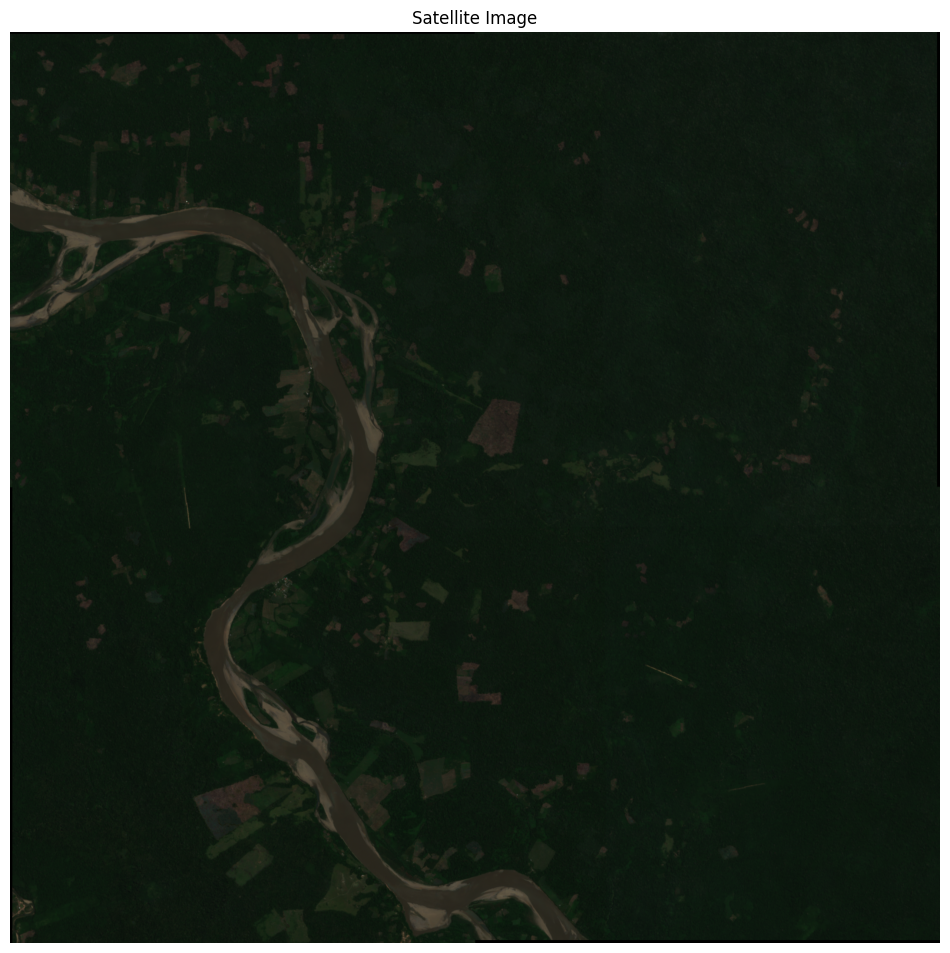

In [184]:
plot_satellite_image(satellite_image)

Overlaying has-strip map...


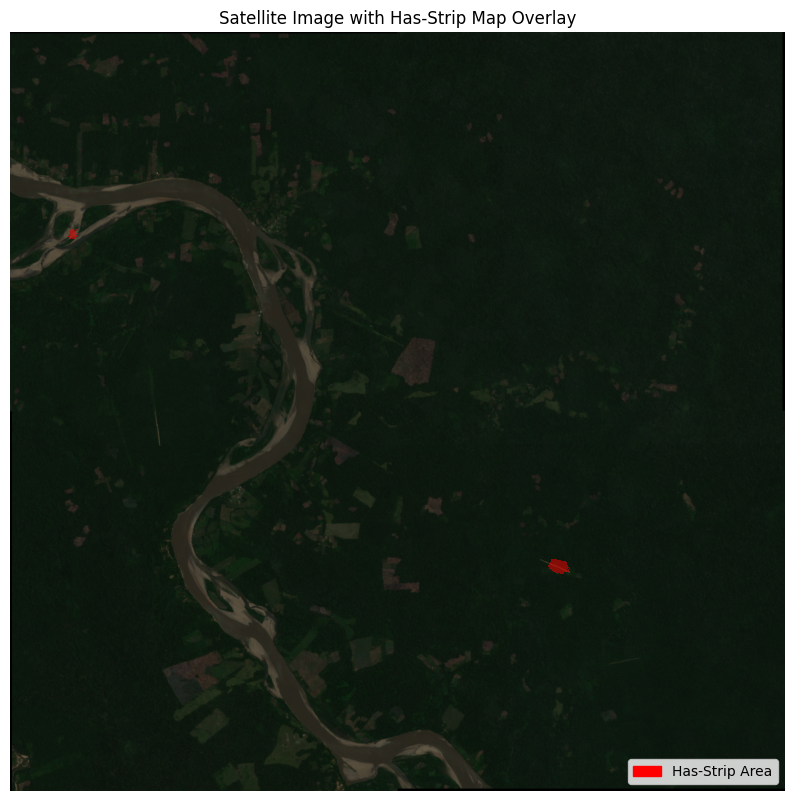

Has-strip map plot displayed.
Overlaying confidence map...


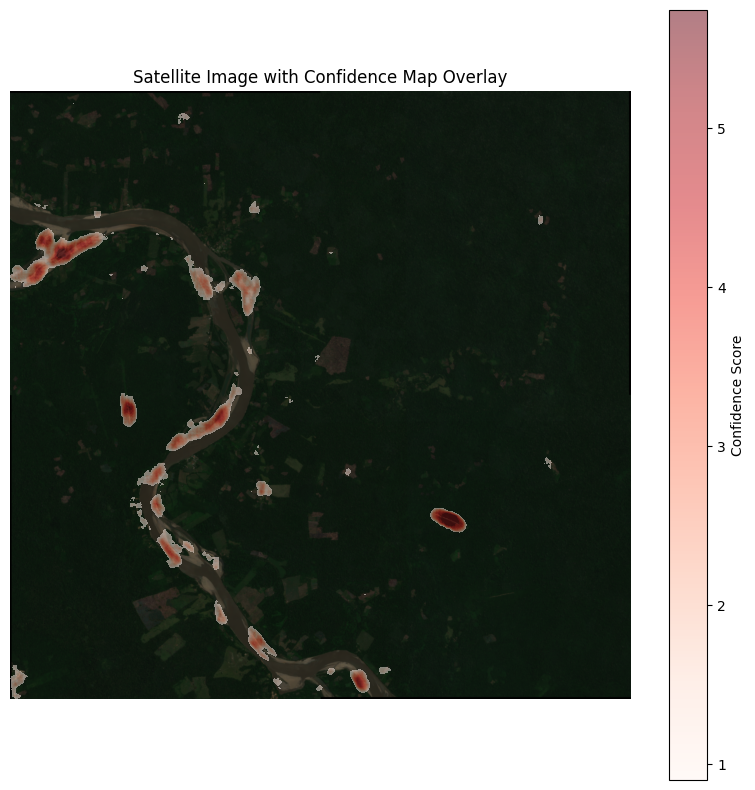

Confidence map plot displayed.


In [185]:

# Example usage
# Assuming you have 'aoi_image', 'confidence_map', and 'has_strip_map' variables
overlay_has_strip_map(satellite_image, has_strip_maps[sample_aoi])
overlay_confidence_map(satellite_image, aoi_confidence_maps[sample_aoi])


In [186]:
satellite_image.shape

(1547, 1579, 3)

In [187]:
# print(plot_predictions(satellite_image, aoi_confidence_maps[sample_aoi], has_strip_maps[sample_aoi]))

In [188]:

# # Example usage
# # Assuming you have 'aoi_image', 'confidence_map', and 'has_strip_map' variables
# overlay_confidence_map(satellite_image, confidence_map)
# overlay_has_strip_map(satellite_image, has_strip_map)


## Make submission CSV

In [189]:
import pandas as pd


def has_strip_tensors_to_submission_csv(
    has_strip_tensors: dict[str, torch.Tensor],
    indexes: str,
    reorder: bool = True,
    csvs_dir: str = '../submission_csvs',
    csv_filename: str = 'submission',
    num_csv_rows: int = 2000000,
    sample_submission_path: str = '../SampleSubmission.csv'
) -> pd.DataFrame:
    """
    Converts the final prediction tensors into a submission CSV file.

    Parameters:
    - has_strip_tensors: Dictionary mapping AOI names to prediction tensors.
    - indexes: Indexing method used ('from-top-left', 'from-bottom-left', 'from-top-right', 'from-bottom-right').
    - reorder: Whether to reorder the output to match the sample submission.
    - csvs_dir: Directory to save the submission CSV.
    - csv_filename: Name of the CSV file to be saved.
    - sample_submission_path: Path to the sample submission CSV.

    Returns:
    - submission_df: A DataFrame containing the submission data.
    """
    import os
    import pandas as pd
    from tqdm import tqdm

    valid_indexes = ['from-top-left', 'from-bottom-left', 'from-top-right', 'from-bottom-right']
    if indexes not in valid_indexes:
        raise NotImplementedError(
            f"Supported indexing methods are {', '.join(valid_indexes)}."
        )

    # Read the sample submission
    sample_submission = pd.read_csv(sample_submission_path)

    # Initialize a list to store the labels
    labels = []

    def convert_aoi_name(aoi_name_in_submission: str) -> str:
        """
        Converts AOI names from the sample submission format to the tensor format.
        E.g., 'aoi_21_02' -> 'aoi_2021_02'
        """
        parts = aoi_name_in_submission.split('_')
        if len(parts) != 3:
            raise ValueError(f"Unexpected AOI name format: {aoi_name_in_submission}")
        prefix, year_short, idx = parts
        year_full = '20' + year_short  # Convert '21' to '2021'
        return f"{prefix}_{year_full}_{idx}"

    sample_submission = sample_submission.head(num_csv_rows)

    # Process each row in the sample submission
    for idx, row in tqdm((sample_submission.iterrows()), total=sample_submission.shape[0]):
        tile_id = row['tile_row_column']  # E.g., 'Tileaoi_21_02_332_448'

        # Remove 'Tile' prefix and split the identifier
        if not tile_id.startswith('Tile'):
            raise ValueError(f"Tile ID does not start with 'Tile': {tile_id}")
        tile_id_no_prefix = tile_id[4:]
        parts = tile_id_no_prefix.split('_')

        if len(parts) != 5:
            raise ValueError(f"Unexpected tile_id format: {tile_id}")

        # Extract AOI name, row, and column indices
        aoi_name_submission = '_'.join(parts[:3])  # 'aoi_21_02'
        row_idx = int(parts[3])
        col_idx = int(parts[4])

        # Convert AOI name to match the keys in has_strip_tensors
        aoi_name = convert_aoi_name(aoi_name_submission)  # 'aoi_2021_02'

        # Retrieve the tensor for the AOI
        if aoi_name not in has_strip_tensors:
            raise ValueError(f"AOI '{aoi_name}' not found in has_strip_tensors")

        tensor = has_strip_tensors[aoi_name]

        # Adjust row and column indices based on indexing method
        if indexes == 'from-top-left':
            adjusted_row_idx = row_idx
            adjusted_col_idx = col_idx
        elif indexes == 'from-bottom-left':
            adjusted_row_idx = (tensor.shape[0] - 1) - row_idx
            adjusted_col_idx = col_idx
        elif indexes == 'from-top-right':
            adjusted_row_idx = row_idx
            adjusted_col_idx = (tensor.shape[1] - 1) - col_idx
        elif indexes == 'from-bottom-right':
            adjusted_row_idx = (tensor.shape[0] - 1) - row_idx
            adjusted_col_idx = (tensor.shape[1] - 1) - col_idx
        else:
            raise NotImplementedError(f"Indexing method '{indexes}' is not supported")

        # Ensure indices are within tensor bounds
        if (adjusted_row_idx < 0 or adjusted_row_idx >= tensor.shape[0] or
            adjusted_col_idx < 0 or adjusted_col_idx >= tensor.shape[1]):
            label = 0  # Assign 0 if indices are out of bounds
        else:
            label = int(tensor[adjusted_row_idx, adjusted_col_idx].item())

        labels.append(label)

    # Add the labels to the DataFrame
    submission_df = sample_submission.copy()
    submission_df['label'] = labels

    # Reorder columns if necessary
    if reorder:
        submission_df = submission_df[['tile_row_column', 'label']]

    # Save to CSV
    os.makedirs(csvs_dir, exist_ok=True)
    submission_csv_path = os.path.join(csvs_dir, f'{csv_filename}.csv')
    submission_df.to_csv(submission_csv_path, index=False)

    print(f"Submission CSV saved to {submission_csv_path}")
    return submission_df


In [190]:
submission_name = f"submission_{train_run.name}"

In [191]:
import os
import numpy as np

# -----------------------------
# Define Directory Paths
# -----------------------------

# Parent directory for label maps
label_maps_parent_dir = '../label_maps'

# Submission-specific directory
submission_dir = os.path.join(label_maps_parent_dir, submission_name)

# Directory for confidence maps
confidence_maps_dir = os.path.join(submission_dir, 'confidence_maps')

# Directory for has strip maps with THRESHOLD in the name
has_strip_maps_dir = os.path.join(submission_dir, f'has_strip_maps_{THRESHOLD}')

# -----------------------------
# Create Directories
# -----------------------------

# Create submission directory
os.makedirs(submission_dir, exist_ok=True)
print(f"Created submission directory: {submission_dir}")

# Create confidence maps directory
os.makedirs(confidence_maps_dir, exist_ok=True)
print(f"Created confidence maps directory: {confidence_maps_dir}")

# Create has strip maps directory with THRESHOLD in the name
os.makedirs(has_strip_maps_dir, exist_ok=True)
print(f"Created has strip maps directory: {has_strip_maps_dir}")


Created submission directory: ../label_maps/submission_peachy-pine-103
Created confidence maps directory: ../label_maps/submission_peachy-pine-103/confidence_maps
Created has strip maps directory: ../label_maps/submission_peachy-pine-103/has_strip_maps_5.743457317352295


In [192]:

# -----------------------------
# Save Confidence Maps
# -----------------------------

for key, map_array in aoi_confidence_maps.items():
    confidence_map_path = os.path.join(confidence_maps_dir, f'{key}.npy')
    np.save(confidence_map_path, map_array)
    print(f"Saved Confidence Map '{key}' to {confidence_map_path}")

# -----------------------------
# Save Has Strip Maps
# -----------------------------

for key, map_array in has_strip_maps.items():
    has_strip_map_path = os.path.join(has_strip_maps_dir, f'{key}.npy')
    np.save(has_strip_map_path, map_array)
    print(f"Saved Has Strip Map '{key}' to {has_strip_map_path}")


Saved Confidence Map 'aoi_2021_04' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2021_04.npy
Saved Confidence Map 'aoi_2022_01' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2022_01.npy
Saved Confidence Map 'aoi_2024_01' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2024_01.npy
Saved Confidence Map 'aoi_2020_02' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2020_02.npy
Saved Confidence Map 'aoi_2021_01' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2021_01.npy
Saved Confidence Map 'aoi_2020_03' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2020_03.npy
Saved Confidence Map 'aoi_2020_01' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2020_01.npy
Saved Confidence Map 'aoi_2022_02' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2022_02.npy
Saved Confidence Map 'aoi_2023_01' to ../label_maps/submission_peachy-pine-103/confidence_maps/aoi_2023_01.npy
S

In [193]:

# -----------------------------
# Generate Submission CSV
# -----------------------------
direction = 'from-bottom-left'

# Define the path for the submission CSV
submission_csv_path = os.path.join(submission_dir, f'{submission_name}--{direction}.csv')

# Generate the submission CSV
submission_df = has_strip_tensors_to_submission_csv(
    has_strip_maps, 
    indexes=direction, 
    csv_filename=submission_name + '--' + direction,
    num_csv_rows=14_000_000,
)
# print(f"Submission CSV saved to {submission_csv_path}")

100%|██████████| 14000000/14000000 [08:41<00:00, 26850.37it/s]


Submission CSV saved to ../submission_csvs/submission_peachy-pine-103--from-bottom-left.csv


In [194]:
# count number of zeros
submission_df['label'].value_counts()

label
0    13992861
1        7139
Name: count, dtype: int64

 ## Notes

In [ ]:
# %%
# - Ensure that the coordinate reference systems (CRS) are consistent throughout the process.
# - Verify the indexing of rows and columns in the `tensor_to_submission_csv` function to match the competition requirements.
# - The code assumes that the helper functions are correctly defined in `inference_utils.py` and `train_utils.py`.
# - Adjust paths and constants as necessary based on your project structure.


 ## Conclusion

In [ ]:
# %%
print("Inference process completed for all AOIs. Submission files are ready.")

